# CNN Architectures on CIFAR-10
Implementation of LeNet-5, AlexNet, VGGNet, ResNet, MobileNet, InceptionV3, and EfficientNet from scratch.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt
import numpy as np
import math
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Data Preparation
# Note: On Kaggle, dataset paths will vary if added manually.
# This setup assumes automated downloading which works if Internet access is enabled on Kaggle kernel.
transform = transforms.Compose([
    transforms.Resize(32), # to make regular size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # 3 channel mean and standard deviation che
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=False, num_workers=2)

cifar_loader = train_loader
cifar_test_loader = test_loader

100%|██████████| 170M/170M [00:03<00:00, 44.4MB/s]


In [ ]:
# LetNet-5 (not original, modified for 3-channel input)
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()

        self.features = nn.Sequential(
            # Changed input channels from 1 to 3 
            nn.Conv2d(3, 6, kernel_size=5),   
            nn.Tanh(),
            nn.AvgPool2d(2, stride=2),        
            nn.Conv2d(6, 16, kernel_size=5),  
            nn.Tanh(),
            nn.AvgPool2d(2, stride=2),        
            nn.Conv2d(16, 120, kernel_size=5),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(120, 84),               
            nn.Tanh(),
            nn.Linear(84, num_classes)        
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  
        x = self.classifier(x)
        return x

In [ ]:
# 2. AlexNet 
class AlexNetCIFAR(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNetCIFAR, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1), # Adapted from 11x11, s4
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [5]:
# 3. VGGNet (VGG-16)
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.features = self._make_layers([64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 
                                           512, 512, 512, 'M', 512, 512, 512, 'M'])
        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 10),
        )

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

In [ ]:
# 4. ResNet 
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = torch.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False) 
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet50(): return ResNet(Bottleneck, [3, 4, 6, 3])
def ResNet101(): return ResNet(Bottleneck, [3, 4, 23, 3])

In [ ]:
# 5. MobileNet (V1)
class Block(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = torch.relu(self.bn2(self.conv2(out)))
        return out

class MobileNet(nn.Module):
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.cfg = [64, 128, 128, 256, 256, 512, 512, 512, 512, 512, 512, 1024, 1024]
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32)
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            stride = 2 if x != in_planes and x != 128 and x != 512 and x!= 64 else 1 
            if x == 64: stride = 1
            if x == 1024 and in_planes == 1024: stride = 1
            layers.append(Block(in_planes, x, stride))
            in_planes = x
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [ ]:
# 6. Inception V1
class Inception(nn.Module):
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=3, padding=1) if n5x5red != 0 else nn.Identity(),
            nn.Conv2d(n5x5, n5x5, kernel_size=5, padding=2) if n5x5red != 0 else nn.Conv2d(in_planes, n5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)

class GoogLeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )

        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(1024, num_classes)

    def forward(self, x):
        out = self.pre_layers(x)
        out = self.a3(out)
        out = self.b3(out)
        out = self.maxpool(out)
        out = self.a4(out)
        out = self.b4(out)
        out = self.c4(out)
        out = self.d4(out)
        out = self.e4(out)
        out = self.maxpool(out)
        out = self.a5(out)
        out = self.b5(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [ ]:
# 7. EfficientNet-B0 
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=4):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.SiLU(),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class MBConv(nn.Module):
    def __init__(self, in_planes, out_planes, expand_ratio, stride, kernel_size=3, reduction=4):
        super(MBConv, self).__init__()
        hidden_dim = in_planes * expand_ratio
        self.use_res_connect = stride == 1 and in_planes == out_planes

        layers = []
        # Expansion phase
        if expand_ratio != 1:
            layers.append(nn.Conv2d(in_planes, hidden_dim, 1, bias=False))
            layers.append(nn.BatchNorm2d(hidden_dim))
            layers.append(nn.SiLU())

        # Depthwise
        layers.append(nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride, 
                                padding=kernel_size//2, groups=hidden_dim, bias=False))
        layers.append(nn.BatchNorm2d(hidden_dim))
        layers.append(nn.SiLU())

        # Squeeze and Excitation
        self.se = SEBlock(hidden_dim, reduction)

        # Pointwise
        layers.append(nn.Conv2d(hidden_dim, out_planes, 1, bias=False))
        layers.append(nn.BatchNorm2d(out_planes))

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x) 
        else:
            return self.conv(x)

class EfficientNetB0(nn.Module):
    def __init__(self, num_classes=10):
        super(EfficientNetB0, self).__init__()
        # Format: [expansion, out_planes, num_blocks, stride, kernel_size]
        self.cfg = [
            [1,  16, 1, 1, 3],
            [6,  24, 2, 1, 3], # Stride 1 to keep spatial dim higher for CIFAR
            [6,  40, 2, 2, 5],
            [6,  80, 3, 2, 3],
            [6, 112, 3, 1, 5],
            [6, 192, 4, 2, 5],
            [6, 320, 1, 1, 3]
        ]
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32)
        self.linear = nn.Linear(320, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for expansion, out_planes, num_blocks, stride, kernel_size in self.cfg:
            strides = [stride] + [1]*(num_blocks-1)
            for s in strides:
                layers.append(MBConv(in_planes, out_planes, expansion, s, kernel_size))
                in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [ ]:
def train_and_evaluate(model_name, model, epochs=5, opt_name='SGD', lr=0.01):
    print(f"--- Training {model_name} | Opt: {opt_name} | LR: {lr} | Epochs: {epochs} ---")
    model = model.to(device)
    
    if opt_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

    criterion = nn.CrossEntropyLoss()
    
    param_count = sum(p.numel() for p in model.parameters())
    print(f"Parameters: {param_count:,}")

    start_time = time.time()
    history = {'loss': [], 'acc': []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        epoch_acc = 100 * correct / total
        history['loss'].append(running_loss / len(train_loader))
        history['acc'].append(epoch_acc)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(train_loader):.4f} | Acc: {epoch_acc:.2f}%")
    
    total_time = time.time() - start_time
    print(f"Total Training Time: {total_time:.2f}s")
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    test_acc = 100 * correct / total
    print(f"Test Accuracy: {test_acc:.2f}%")
    
    return history, test_acc, total_time, param_count

In [ ]:
results = []

configs = [
    ("LeNet5", LeNet5(), 10, "SGD", 0.01),
    ("AlexNet", AlexNetCIFAR(), 10, "SGD", 0.01),
    ("VGG16", VGG(), 10, "SGD", 0.01),
    ("MobileNet", MobileNet(), 15, "Adam", 0.001), 
    ("GoogLeNet", GoogLeNet(), 15, "SGD", 0.01),
    ("EfficientNet-B0", EfficientNetB0(), 15, "Adam", 0.001),
    ("ResNet50", ResNet50(), 15, "SGD", 0.1),
    ("ResNet101", ResNet101(), 15, "SGD", 0.1), 
]

for name, model, epochs, opt, lr in configs:
    hist, acc, t, params = train_and_evaluate(name, model, epochs=epochs, opt_name=opt, lr=lr)
    results.append((name, acc, t, params))

--- Training LeNet5 | Opt: SGD | LR: 0.01 | Epochs: 10 ---
Parameters: 62,006
Epoch 1/10 | Loss: 1.9544 | Acc: 29.01%
Epoch 2/10 | Loss: 1.7240 | Acc: 38.93%
Epoch 3/10 | Loss: 1.5800 | Acc: 43.61%
Epoch 4/10 | Loss: 1.4402 | Acc: 48.07%
Epoch 5/10 | Loss: 1.3627 | Acc: 51.01%
Epoch 6/10 | Loss: 1.3116 | Acc: 53.02%
Epoch 7/10 | Loss: 1.2712 | Acc: 54.66%
Epoch 8/10 | Loss: 1.2303 | Acc: 55.99%
Epoch 9/10 | Loss: 1.2037 | Acc: 57.14%
Epoch 10/10 | Loss: 1.1732 | Acc: 58.15%
Total Training Time: 80.53s
Test Accuracy: 56.35%
--- Training AlexNet | Opt: SGD | LR: 0.01 | Epochs: 10 ---
Parameters: 23,272,266
Epoch 1/10 | Loss: 2.3016 | Acc: 10.62%
Epoch 2/10 | Loss: 2.0589 | Acc: 20.59%
Epoch 3/10 | Loss: 1.7174 | Acc: 32.85%
Epoch 4/10 | Loss: 1.5039 | Acc: 42.55%
Epoch 5/10 | Loss: 1.3268 | Acc: 50.68%
Epoch 6/10 | Loss: 1.1834 | Acc: 56.81%
Epoch 7/10 | Loss: 1.0460 | Acc: 61.82%
Epoch 8/10 | Loss: 0.9385 | Acc: 66.17%
Epoch 9/10 | Loss: 0.8553 | Acc: 69.40%
Epoch 10/10 | Loss: 0.7671 |

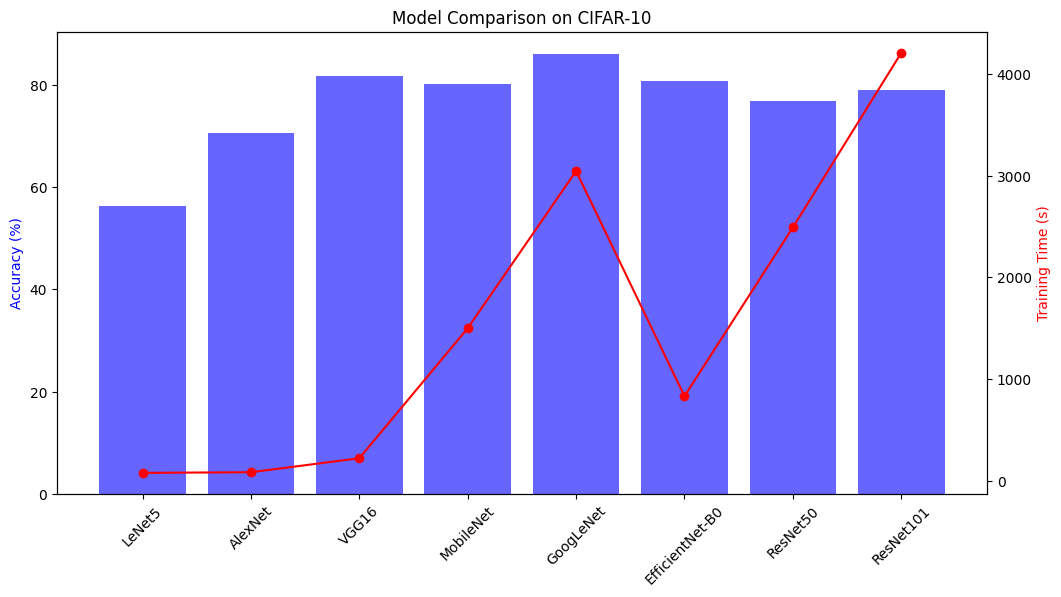

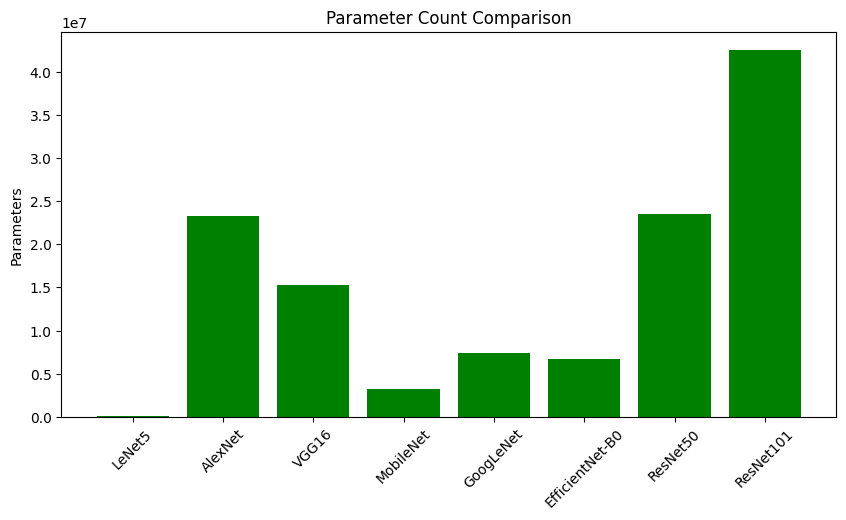

In [ ]:
names = [r[0] for r in results]
accs = [r[1] for r in results]
times = [r[2] for r in results]
params = [r[3] for r in results]

x = np.arange(len(names))

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.bar(x, accs, color='b', alpha=0.6, label='Accuracy (%)')
ax1.set_ylabel('Accuracy (%)', color='b')
ax1.set_xticks(x)
ax1.set_xticklabels(names, rotation=45)

ax2 = ax1.twinx()
ax2.plot(x, times, color='r', marker='o', label='Time (s)')
ax2.set_ylabel('Training Time (s)', color='r')

plt.title("Model Comparison on CIFAR-10")
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(names, params, color='g')
plt.ylabel("Parameters")
plt.title("Parameter Count Comparison")
plt.xticks(rotation=45)
plt.show()

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

class ArcFaceModelWrapper(nn.Module):
    def __init__(self, base_model, embedding_size, num_classes):
        super(ArcFaceModelWrapper, self).__init__()
        self.base_model = base_model
        self.arc_head = ArcMarginProduct(embedding_size, num_classes)
        self.embedding_size = embedding_size
        
    def forward(self, x, labels=None):
        # Determine how to extract features based on model type
        if hasattr(self.base_model, 'linear'): # ResNet / MobileNet
            x = self.base_model.conv1(x)
            x = self.base_model.bn1(x)
            x = torch.relu(x)
            x = self.base_model.layer1(x)
            x = self.base_model.layer2(x)
            x = self.base_model.layer3(x)
            x = self.base_model.layer4(x)
            x = F.avg_pool2d(x, 4)
            features = x.view(x.size(0), -1)
        elif hasattr(self.base_model, 'classifier'): # VGG / AlexNet
             x = self.base_model.features(x)
             x = x.view(x.size(0), -1)

             for i, layer in enumerate(self.base_model.classifier):
                 if i == len(self.base_model.classifier) - 1: # Skip last Linear
                     break
                 x = layer(x)
             features = x
        else:
            features = x # fallback
            
        if labels is not None:
             return self.arc_head(features, labels)
        return features

In [ ]:
mnist_transform = transforms.Compose([
    transforms.Resize(32), 
    transforms.Grayscale(num_output_channels=3), 
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=mnist_transform)
mnist_loader = torch.utils.data.DataLoader(mnist_train, batch_size=128, shuffle=True)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=mnist_transform)
mnist_test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

print("MNIST and CIFAR datasets prepared.")

100%|██████████| 9.91M/9.91M [00:00<00:00, 40.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.11MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.71MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.83MB/s]

MNIST and CIFAR datasets prepared.


In [ ]:
def train_part2(model, optimizer, scheduler, criterion, loader, valid_loader, epochs, model_name, loss_name):
    print(f"\n--- Training {model_name} with {loss_name} ---")
    model = model.to(device)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            # Special handling for ArcFace (requires labels in forward)
            if loss_name == "ArcFace":
                outputs = model(inputs, labels) # Returns angular margin logits
                loss = criterion(outputs, labels)
            else:
                outputs = model(inputs)
                
                # Special handling for BCE (requires One-Hot)
                if loss_name == "BCE":
                    target_one_hot = F.one_hot(labels, num_classes=10).float()
                    loss = criterion(outputs, target_one_hot)
                else: 
                    # CrossEntropy or FocalLoss
                    loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(loader):.4f} | Acc: {100*correct/total:.2f}%")
        
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            if loss_name == "ArcFace":
                embeddings = model(inputs) 
                w = model.arc_head.weight
                cosine = F.linear(F.normalize(embeddings), F.normalize(w))
                outputs = cosine * 30.0 
            else:
                outputs = model(inputs)
                
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
    final_acc = 100 * correct / total
    print(f"Final Test Acc: {final_acc:.2f}%")
    return model, final_acc

experiments = [
    {
        "model_cls": VGG, "data": "MNIST", "loader": mnist_loader, "valid": mnist_test_loader,
        "opt": "Adam", "epochs": 10, "loss": "BCE", "criterion": nn.BCEWithLogitsLoss() 
    },
    {
        "model_cls": AlexNetCIFAR, "data": "CIFAR", "loader": cifar_loader, "valid": cifar_test_loader,
        "opt": "SGD", "epochs": 20, "loss": "Focal Loss", "criterion": FocalLoss() 
    },
    {
        "model_cls": ResNet50, "data": "CIFAR", "loader": cifar_loader, "valid": cifar_test_loader,
        "opt": "Adam", "epochs": 15, "loss": "ArcFace", "criterion": nn.CrossEntropyLoss()
    }
]

trained_models = {}

for i, exp in enumerate(experiments):
    print(f"\nRunning Experiment {i+1}: {exp['model_cls'].__name__} on {exp['data']} with {exp['loss']}")
    
    base_model = exp["model_cls"]()
    
    if exp["loss"] == "ArcFace":
        if isinstance(base_model, ResNet): frame_size = 2048 # ResNet50 expansion * 512
        elif isinstance(base_model, VGG): frame_size = 512 
        else: frame_size = 512
        emb_dim = 2048 
        
        model = ArcFaceModelWrapper(base_model, emb_dim, 10)
    else:
        model = base_model

    if exp["opt"] == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    else:
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        
    model, acc = train_part2(model, optimizer, None, exp["criterion"], exp["loader"], exp["valid"], exp["epochs"], str(base_model.__class__.__name__), exp["loss"])
    
    trained_models[f"Exp_{i+1}_{exp['loss']}"] = model


Running Experiment 1: VGG on MNIST with BCE

--- Training VGG with BCE ---
Epoch 1/10 | Loss: 0.1627 | Acc: 58.24%
Epoch 2/10 | Loss: 0.0168 | Acc: 97.72%
Epoch 3/10 | Loss: 0.0118 | Acc: 98.47%
Epoch 4/10 | Loss: 0.0099 | Acc: 98.67%
Epoch 5/10 | Loss: 0.0075 | Acc: 99.03%
Epoch 6/10 | Loss: 0.0070 | Acc: 99.12%
Epoch 7/10 | Loss: 0.0068 | Acc: 99.16%
Epoch 8/10 | Loss: 0.0054 | Acc: 99.33%
Epoch 9/10 | Loss: 0.0059 | Acc: 99.19%
Epoch 10/10 | Loss: 0.0055 | Acc: 99.31%
Final Test Acc: 99.24%

Running Experiment 2: AlexNetCIFAR on CIFAR with Focal Loss

--- Training AlexNetCIFAR with Focal Loss ---
Epoch 1/20 | Loss: 1.8624 | Acc: 10.26%
Epoch 2/20 | Loss: 1.4603 | Acc: 23.27%
Epoch 3/20 | Loss: 1.1077 | Acc: 37.01%
Epoch 4/20 | Loss: 0.8996 | Acc: 46.01%
Epoch 5/20 | Loss: 0.7776 | Acc: 52.62%
Epoch 6/20 | Loss: 0.6701 | Acc: 58.36%
Epoch 7/20 | Loss: 0.5952 | Acc: 62.65%
Epoch 8/20 | Loss: 0.5200 | Acc: 66.22%
Epoch 9/20 | Loss: 0.4620 | Acc: 69.40%
Epoch 10/20 | Loss: 0.4084 | Acc

Visualizing Part 3 Results...


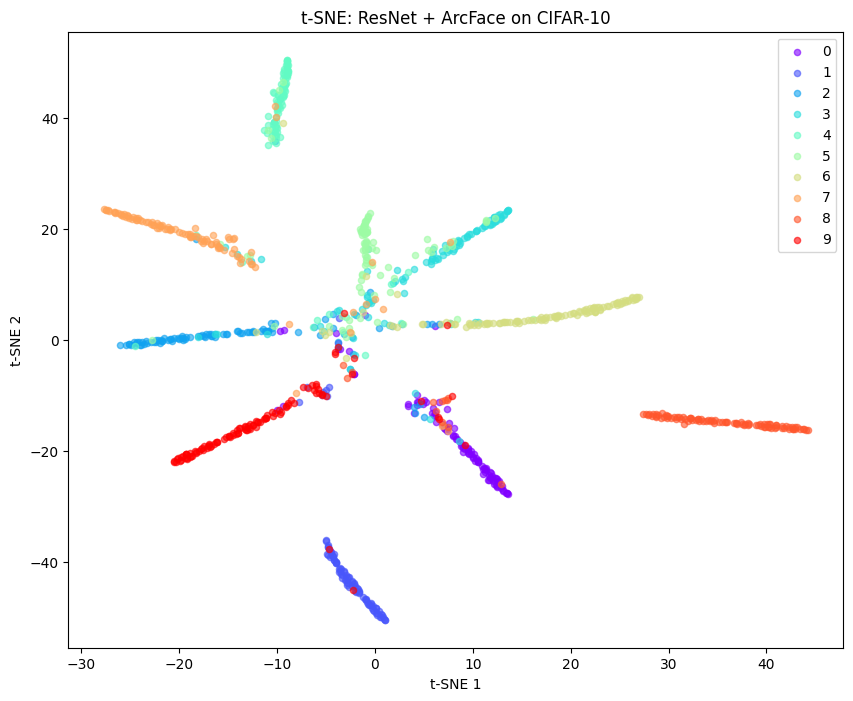

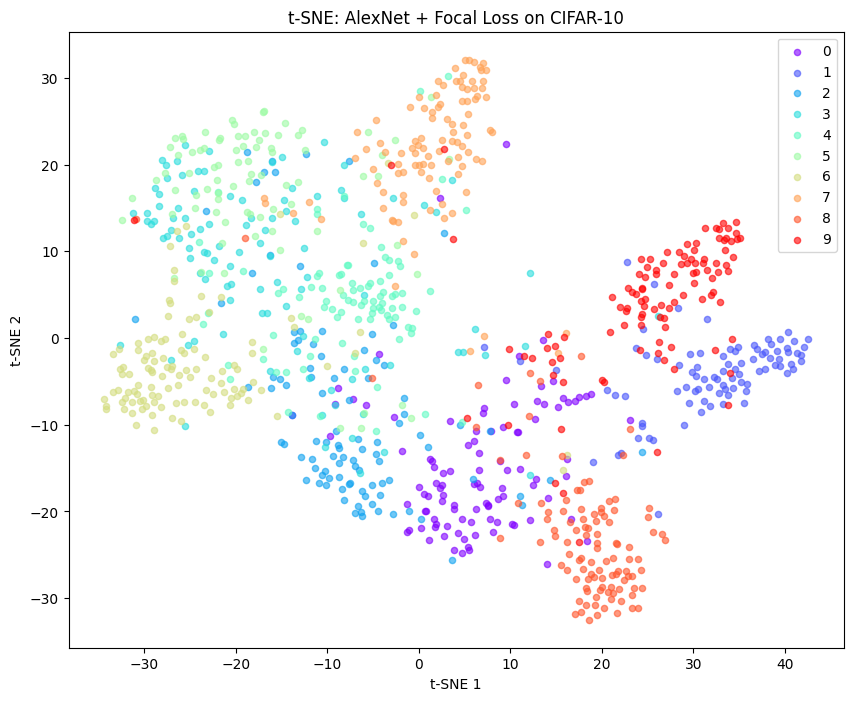

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm

def visualize_features(model, loader, title, is_arcface=False):
    model.eval()
    features_list = []
    labels_list = []
    
    limit = 1000 
    count = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            if is_arcface:
                features = model(inputs) 
            else:
                if hasattr(model, 'linear'): # ResNet / MobileNet
                     # Manual forward copy
                     x = model.conv1(inputs)
                     x = model.bn1(x)
                     x = torch.relu(x)
                     x = model.layer1(x)
                     x = model.layer2(x)
                     x = model.layer3(x) 
                     x = model.layer4(x)
                     x = F.avg_pool2d(x, 4)
                     features = x.view(x.size(0), -1)
                elif hasattr(model, 'features'): # VGG
                     x = model.features(inputs)
                     x = x.view(x.size(0), -1)
                     features = x # Approximate for VGG (skipping classifier layers for t-SNE on high level features)
                else:
                    features = model(inputs) # Fallback to logits if extraction fails

            features_list.append(features.cpu())
            labels_list.append(labels.cpu())
            
            count += inputs.size(0)
            if count >= limit: break

    features = torch.cat(features_list, dim=0)[:limit]
    labels = torch.cat(labels_list, dim=0)[:limit]
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    features_2d = tsne.fit_transform(features.numpy())
    
    plt.figure(figsize=(10, 8))
    colors = cm.rainbow(np.linspace(0, 1, 10))
    for i in range(10):
        inds = (labels == i).numpy()
        plt.scatter(features_2d[inds, 0], features_2d[inds, 1], color=colors[i], label=str(i), alpha=0.6, s=20)
    
    plt.legend()
    plt.title(title)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.show()

print("Visualizing Part 3 Results...")

if "Exp_3_ArcFace" in trained_models:
    visualize_features(trained_models["Exp_3_ArcFace"], cifar_test_loader, "t-SNE: ResNet + ArcFace on CIFAR-10", is_arcface=True)

if "Exp_2_Focal Loss" in trained_models:
    visualize_features(trained_models["Exp_2_Focal Loss"], cifar_test_loader, "t-SNE: AlexNet + Focal Loss on CIFAR-10", is_arcface=False)
